In [4]:
import pandas as pd
import numpy as np
import subprocess
import seaborn as sns

In [ ]:
plink2 --vcf --make-bed --out gemma_in

In [ ]:
%%bash
source ~/.bashrc
conda activate gemma
gemma -bfile gemma_in \
    -gk <1 or 2> \
    -o <output prefix>

In [11]:
%%bash
source ~/.bashrc
conda activate masters

plink2 \
       --threads 10 \
       --pheno 'iid-only' ../phenotypes_final.pheno \
       --vcf ../shapeit_phase/FL.phased_tagged_filtered.vcf.gz \
       --glm hide-covar hetonly \
       --maf 0.1 \
       --covar ../covars_final.covar \
       --adjust --extract range ../chrs.bed \
       --pheno-quantile-normalize --covar-variance-standardize \
       --allow-extra-chr --set-missing-var-ids @:# \
       --out test \
       --memory 120000 \
       --require-pheno

PLINK v2.00a5LM 64-bit Intel (23 Sep 2023)     www.cog-genomics.org/plink/2.0/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to test.log.
Options in effect:
  --adjust
  --allow-extra-chr
  --covar ../covars_final.covar
  --covar-variance-standardize
  --extract range ../chrs.bed
  --glm hide-covar hetonly
  --maf 0.1
  --memory 128000
  --out test
  --pheno iid-only ../phenotypes_final.pheno
  --pheno-quantile-normalize
  --require-pheno
  --set-missing-var-ids @:#
  --threads 10
  --vcf ../calls/gwas_dataset_expanded.vcf.gz

Start time: Wed Jan 24 13:32:44 2024
257826 MiB RAM detected, ~241268 available; reserving 128000 MiB for main
workspace.
Using up to 10 threads (change this with --threads).


Task exception was never retrieved
future: <Task finished name='Task-22' coro=<ScriptMagics.shebang.<locals>._handle_stream() done, defined at /storage/group/ibb3/default/.conda/envs/masters/lib/python3.10/site-packages/IPython/core/magics/script.py:211> exception=ValueError('Separator is not found, and chunk exceed the limit')>
Traceback (most recent call last):
  File "/storage/group/ibb3/default/.conda/envs/masters/lib/python3.10/asyncio/streams.py", line 524, in readline
    line = await self.readuntil(sep)
  File "/storage/group/ibb3/default/.conda/envs/masters/lib/python3.10/asyncio/streams.py", line 602, in readuntil
    raise exceptions.LimitOverrunError(
asyncio.exceptions.LimitOverrunError: Separator is not found, and chunk exceed the limit

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/storage/group/ibb3/default/.conda/envs/masters/lib/python3.10/site-packages/IPython/core/magics/script.py", line 213, in _han

In [58]:
bed = pd.read_csv("../references/apal_and_sym.bed", sep = '\t', header = None)

In [13]:
chrs = ["Apal_hic_scaffold_4", "Apal_hic_scaffold_2", "Apal_hic_scaffold_10", 
                 "Apal_hic_scaffold_15", "Apal_hic_scaffold_17", "Apal_hic_scaffold_20", 
                 "Apal_hic_scaffold_31", "Apal_hic_scaffold_30", "Apal_hic_scaffold_6", 
                 "Apal_hic_scaffold_35", "Apal_hic_scaffold_5", "Apal_hic_scaffold_11", 
                 "Apal_hic_scaffold_21", "Apal_hic_scaffold_1"]

In [63]:
bed[bed[0].isin(chrs)].set_index(0).to_csv("../chrs.bed", sep = "\t")

In [12]:
for interaction in ["hetonly", "genotypic", "dominant", "recessive"]:
    task = "plink2_gwas"
    mem = "256"
    cpus = "20"
    infile = "../shapeit_phase/FL.phased_tagged_filtered.vcf.gz"
    outpath = "../gwas"
    pheno = "../phenotypes.pheno"
    covar = "../covar.cov"
    glmargs = interaction
    maf = str(0.1)
    subprocess.run(["sbatch --mem=" + mem + "g --ntasks=" + 
         cpus + " ../" + task + ".sh " + 
         infile + " " + outpath + " " + pheno + " " + 
                    covar + " " + glmargs + " " + glmargs + " " + maf], shell=True)

Submitted batch job 8667844
Submitted batch job 8667845
Submitted batch job 8667846
Submitted batch job 8667847


In [10]:
pval = pd.read_csv("../gwas/hetonly.Fixed_ED50.glm.linear.adjusted", sep = "\t")
q = pd.read_csv("../gwas/hetonly.Fixed_ED50.glm.linear", sep = "\t")

In [15]:
chr_rename = {"Apal_hic_scaffold_4":"1", 
              "Apal_hic_scaffold_2":"3", 
              "Apal_hic_scaffold_10":"2", 
                 "Apal_hic_scaffold_15":"8", 
              "Apal_hic_scaffold_17":"5", 
              "Apal_hic_scaffold_20":"4", 
                 "Apal_hic_scaffold_31":"6", 
              "Apal_hic_scaffold_30":"10", 
              "Apal_hic_scaffold_6":"9", 
                 "Apal_hic_scaffold_35":"7", 
              "Apal_hic_scaffold_5":"11", 
              "Apal_hic_scaffold_11":"14", 
                 "Apal_hic_scaffold_21":"13", 
              "Apal_hic_scaffold_1":"12"}

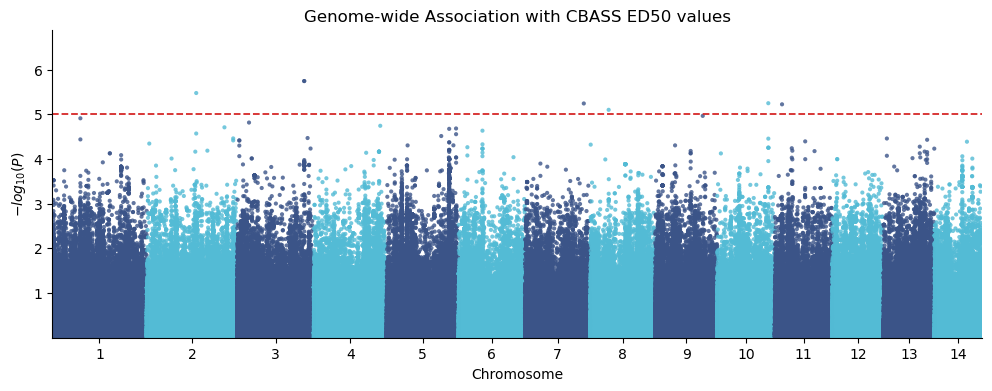

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from qmplot import manhattanplot

if __name__ == "__main__":

    # loading data from local file
    
    xtick = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14"]
    
    df = pd.read_csv("./test.logSh.glm.linear", sep = "\t")
    df["#CHROM"] = df["#CHROM"].replace(chr_rename)
    df["#CHROM"] = df["#CHROM"].astype(int)
    df["ID"] = df["#CHROM"].astype(str) + ":" + df["POS"].astype(str)
    df = df.sort_values(["#CHROM", "POS"])
    df = df.dropna(how="any", axis=0)  # clean data
    
    # defined the plot style
    f, ax = plt.subplots(figsize=(12, 4), facecolor='w', edgecolor='k')
    manhattanplot(data=df,
                  marker=".",
                  sign_marker_p=1e-6,  # Genome wide significant p-value
                  sign_marker_color="r",
                  snp="ID",

                  title="Genome-wide Association with CBASS ED50 values",
                  xlabel="Chromosome",
                  ylabel=r"$-log_{10}{(P)}$",
                  xtick_label_set=xtick,

                  sign_line_cols=["#D62728", "#2CA02C"],
                  hline_kws={"linestyle": "--", "lw": 1.3},

                  is_annotate_topsnp=True,
                  ld_block_size=0,  # 500000 bp
                  text_kws={"fontsize": 12,  # The fontsize of annotate text
                            "arrowprops": dict(arrowstyle="-", color="k", alpha=0.6)},
                  ax=ax)
    #plt.savefig("../GWAS.png", dpi = 300)

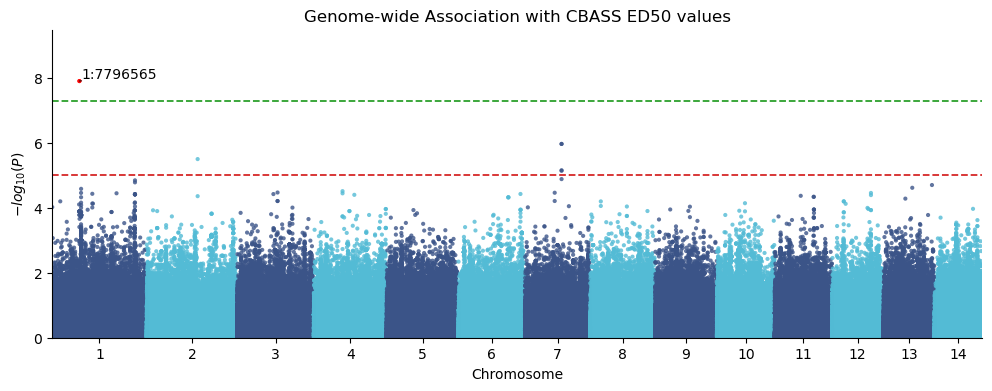

In [95]:
import matplotlib.pyplot as plt
import pandas as pd
from qmplot import manhattanplot

if __name__ == "__main__":

    # loading data from local file
    
    xtick = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14"]
    
    df = pd.read_csv("../gwas/hetonly.Fixed_ED50.glm.linear", sep = "\t")
    df["#CHROM"] = df["#CHROM"].replace(chr_rename)
    df["#CHROM"] = df["#CHROM"].astype(int)
    df["ID"] = df["#CHROM"].astype(str) + ":" + df["POS"].astype(str)
    df = df.sort_values(["#CHROM", "POS"])
    df = df.dropna(how="any", axis=0)  # clean data
    
    # defined the plot style
    f, ax = plt.subplots(figsize=(12, 4), facecolor='w', edgecolor='k')
    manhattanplot(data=df,
                  marker=".",
                  sign_marker_p=1e-6,  # Genome wide significant p-value
                  sign_marker_color="r",
                  snp="ID",

                  title="Genome-wide Association with CBASS ED50 values",
                  xlabel="Chromosome",
                  ylabel=r"$-log_{10}{(P)}$",
                  xtick_label_set=xtick,

                  sign_line_cols=["#D62728", "#2CA02C"],
                  hline_kws={"linestyle": "--", "lw": 1.3},

                  is_annotate_topsnp=True,
                  ld_block_size=0,  # 500000 bp
                  text_kws={"fontsize": 12,  # The fontsize of annotate text
                            "arrowprops": dict(arrowstyle="-", color="k", alpha=0.6)},
                  ax=ax)
    plt.savefig("../GWAS.png", dpi = 300)

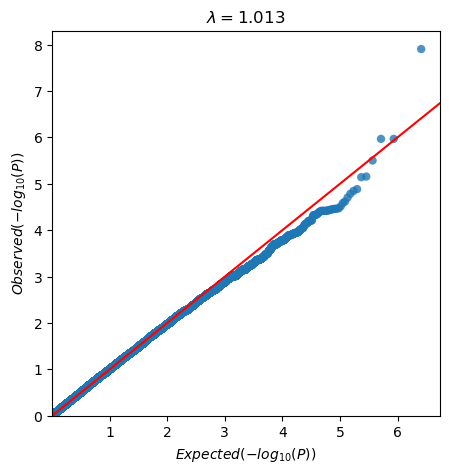

In [96]:
import pandas as pd
from qmplot import qqplot
if __name__ == "__main__":
    df = pd.read_csv("../gwas/hetonly.Fixed_ED50.glm.linear", sep = "\t")
    df["#CHROM"] = df["#CHROM"].replace(chr_rename)
    df["#CHROM"] = df["#CHROM"].astype(int)
    df["ID"] = df["#CHROM"].astype(str) + ":" + df["POS"].astype(str)
    df = df.sort_values(["#CHROM", "POS"])
    df = df.dropna(how="any", axis=0)  # clean data
    ax = qqplot(data=df["P"])
    plt.savefig("../GWAS_QQ.png", dpi = 300)

In [15]:
import pandas as pd
import numpy as np

In [16]:
annotations = pd.read_csv("/storage/group/ibb3/default/AP_AC_genome_seqs/dovetail_Apalm/HiC_improvement/APdov_v3.1_GeneAnnotation_combined.txt", sep = "\t")

/tmp/ipykernel_2258137/1726066674.py:1: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv("/storage/group/ibb3/default/AP_AC_genome_seqs/dovetail_Apalm/HiC_improvement/APdov_v3.1_GeneAnnotation_combined.txt", sep = "\t")


In [25]:
annotations[annotations["Scaffold"] == 'hic_scaffold_35'][annotations["Start"] > 10454500][annotations["End"] < 10479000]

/tmp/ipykernel_2258137/315270717.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations[annotations["Scaffold"] == 'hic_scaffold_35'][annotations["Start"] > 10454500][annotations["End"] < 10479000]


,Gene ID v3,Removed/Split in v3.0,Scaffold,Start,End,Gene Annotation,Swiss-Prot Hit,E-value,Swiss-Prot Description,Trembl Hit,...,"KEGG ID, threshold 60","KEGG ID, threshold 30",OrthoDB match,OrthoDB evalue,OrthoDB annotation,Match to Apalm v1 genome,Percent Identity v1 to v2,Gene Name v2,"""transposon""",Gene Model Support
21348,evm.model.hic_scaffold_35.1169,NaN,hic_scaffold_35,10463984.0,10475706.0,40S ribosomal protein S2,Q90YS3,1.700000e-144,40S ribosomal protein S2 OS=Ictalurus punctatu...,A0A2B4SNM2,...,K02981,K02981,7404at6101,0.0,NaN,Apalm_gene.model.Segkk1662_pilon.11,100.0,Apalm_v2_gene.model.Sc0a5M3_401_HRSCAF_746.307,no,"GeneMark.hmm,HiQ,PASA,Augustus"


In [28]:
annotations[annotations["Scaffold"] == 'hic_scaffold_10'][annotations["Start"] > 14575788][annotations["End"] < 14595788]

/tmp/ipykernel_2258137/1446756259.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations[annotations["Scaffold"] == 'hic_scaffold_10'][annotations["Start"] > 14575788][annotations["End"] < 14595788]


,Gene ID v3,Removed/Split in v3.0,Scaffold,Start,End,Gene Annotation,Swiss-Prot Hit,E-value,Swiss-Prot Description,Trembl Hit,...,"KEGG ID, threshold 60","KEGG ID, threshold 30",OrthoDB match,OrthoDB evalue,OrthoDB annotation,Match to Apalm v1 genome,Percent Identity v1 to v2,Gene Name v2,"""transposon""",Gene Model Support
2996,evm.model.hic_scaffold_10.1367,NaN,hic_scaffold_10,14580071.0,14594123.0,"Glycerol-3-phosphate acyltransferase 1, mitoch...",Q61586,4.260000e-128,"Glycerol-3-phosphate acyltransferase 1, mitoch...",A0A2B4S4T0,...,K00629,K00629,1852at6101,0.0,"glycerol-3-phosphate acyltransferase 1, mitoch...",Apalm_gene.model.Segkk424_pilon.34,100.0,Apalm_v2_gene.model.Sc0a5M3_281_HRSCAF_464.1043,no,"GeneMark.hmm,PASA,Augustus"


In [ ]:
14583788